# Análisis de Consumo Energético y Clustering con K-Means

## Objetivos del Cuaderno

1. **Clustering con K-Means**: Aplicar el algoritmo de K-Means para agrupar las viviendas en función de sus patrones de consumo energético.
6. **Validación del Modelo**: Evaluar la calidad de los clusters generados utilizando metedos y visualizaciones adecuadas.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("dataset/features_StandardScaler.csv", index_col='cups')

In [ ]:
X = df.values
best_k = 7

In [ ]:
df_features_final = pd.read_csv("dataset/features_KNNImputer.csv", index_col='cups')

In [ ]:
with open("pkls/kmeans_24h_model_watts.pkl", "rb") as f:
    kmeans_final = pickle.load(f)

if hasattr(kmeans_final, 'labels_'):
    labels = kmeans_final.labels_

if hasattr(kmeans_final, 'cluster_centers_'):
    centroids = kmeans_final.cluster_centers_

### Variables más influyentes según varianza entre clusters

In [105]:
centroides = pd.DataFrame(
    kmeans_final.cluster_centers_,
    columns=df_features_final.columns
)

variabilidad = centroides.var(axis=0).sort_values(ascending=False)
print(variabilidad)

p25_verano                        11.463045
p25_invierno                      10.730492
mediana_verano                     8.831904
mediana_anual                      8.469400
energia_fft_verano                 7.040776
mediana_invierno                   6.930510
mediana_primavera                  6.902189
media_verano                       5.713270
skewness_verano                    5.272519
media_anual                        5.025490
media_invierno                     4.990195
kurtosis_verano                    4.900398
p75_anual                          4.607742
p75_verano                         4.596130
skewness_anual                     4.436855
energia_fft_anual                  4.393878
media_primavera                    4.157131
p75_primavera                      4.120679
p75_invierno                       4.023867
energia_fft_invierno               4.010187
kurtosis_anual                     3.955871
p25_anual                          3.690792
p75_otoño                       

## Visualización de Resultados de Clustering

In [106]:
cluster_colors = cm.get_cmap('tab10', best_k)

#### Visualización de los Centros de los Clusters

Graficamos los valores de los centros de cada cluster en todas las columnas (features) del dataset

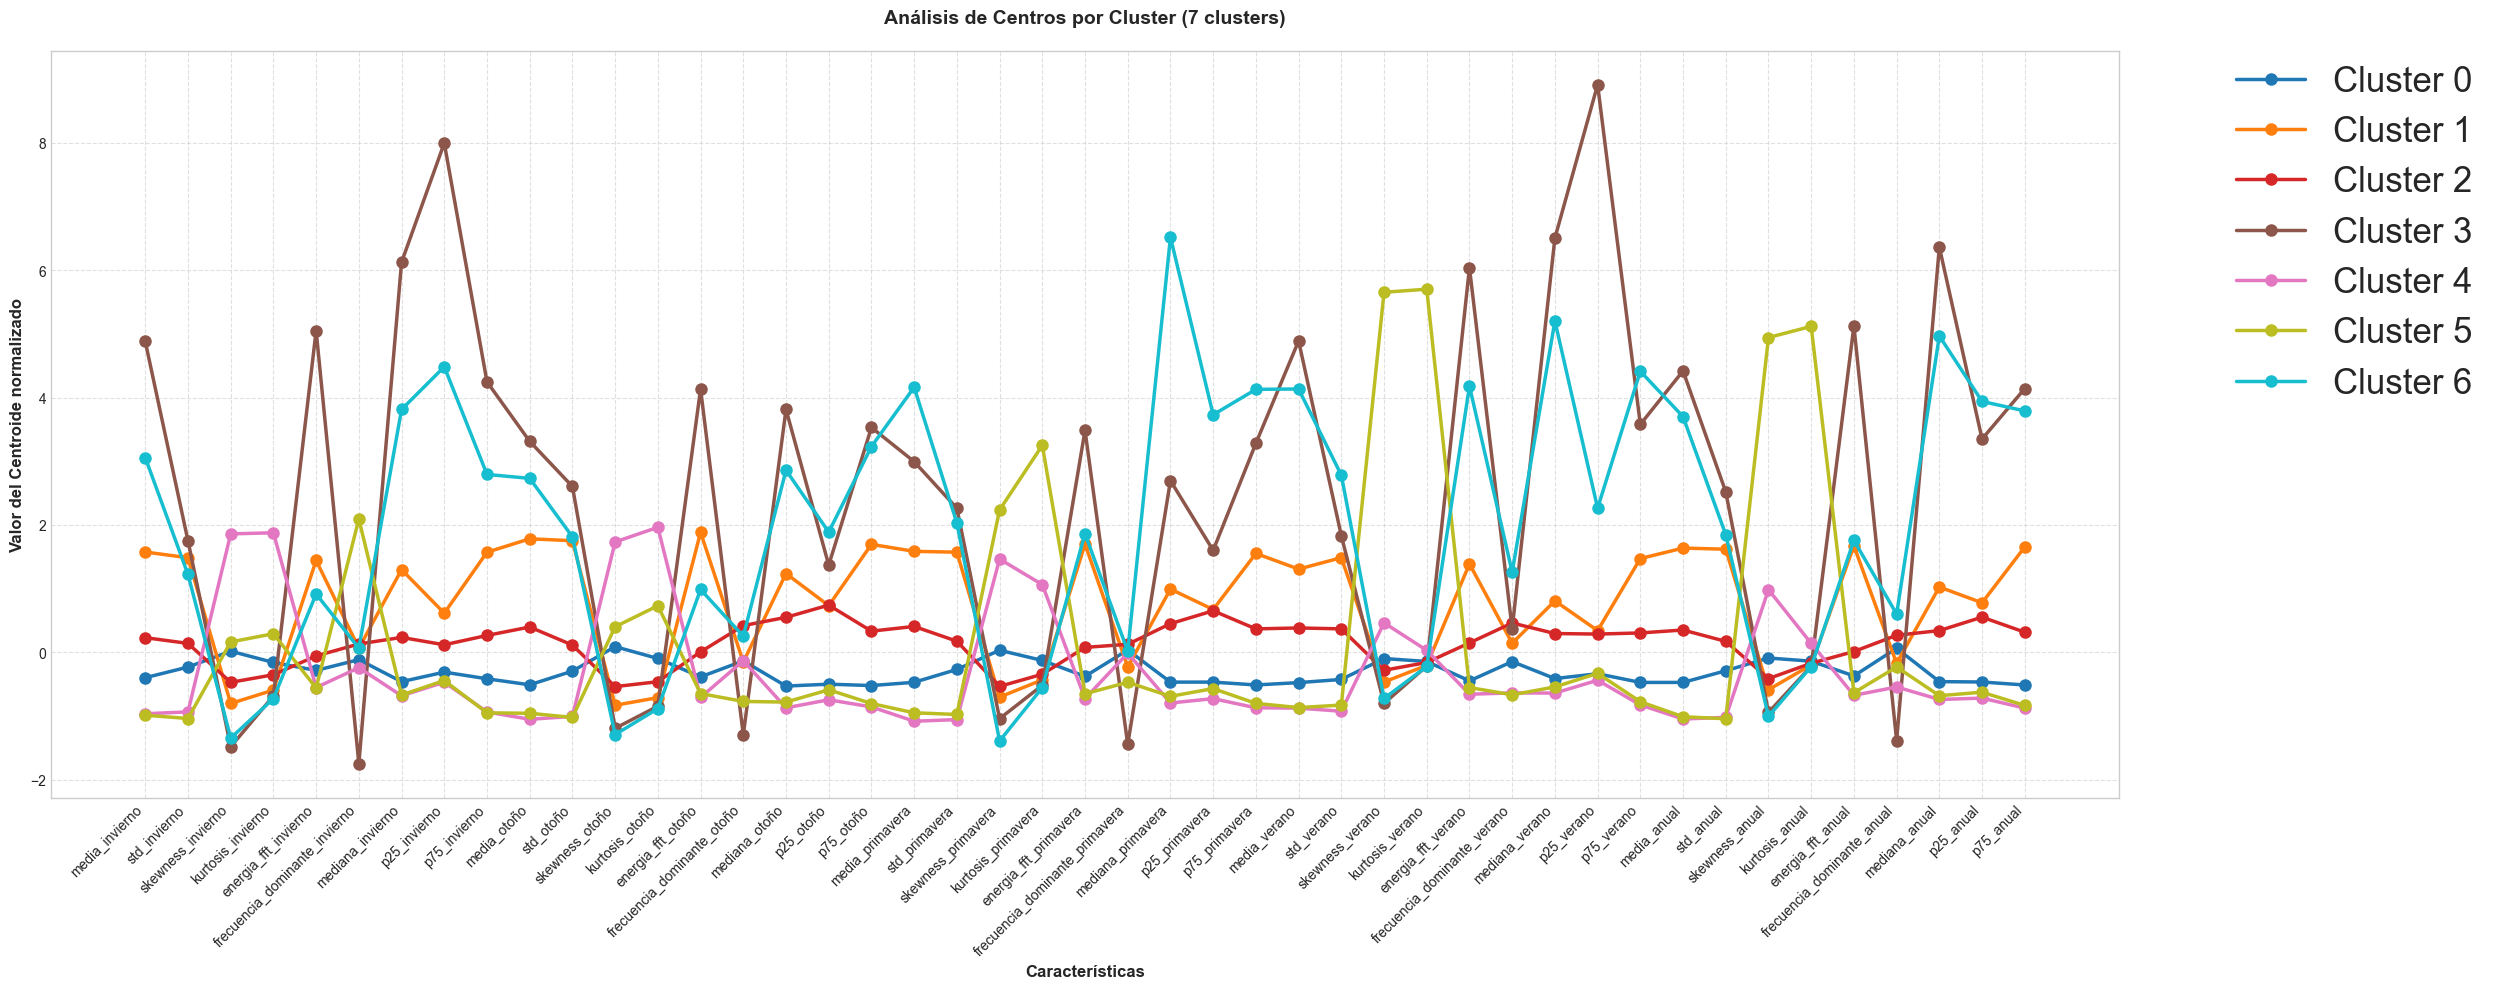

In [107]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.facecolor'] = 'white'
feature_names = df_features_final.columns
plt.figure(figsize=(25, 10))

for i in range(best_k):
    plt.plot(kmeans_final.cluster_centers_[i], 
             label=f'Cluster {i}',
             marker='o',
             markersize=8,
             linewidth=2.5,
             color=cluster_colors(i))

plt.xticks(np.arange(len(feature_names)), 
           feature_names, 
           rotation=45, 
           ha='right',
           fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Características', fontsize=12, fontweight='bold')
plt.ylabel('Valor del Centroide normalizado', fontsize=12, fontweight='bold')
plt.title(f'Análisis de Centros por Cluster ({best_k} clusters)', 
          fontsize=14, 
          fontweight='bold', 
          pad=20)
plt.legend(bbox_to_anchor=(1.05, 1), 
           loc='upper left', 
           borderaxespad=0.,
           fontsize=25)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Visualización de Clusters PCA

#### 1. PCA 2D

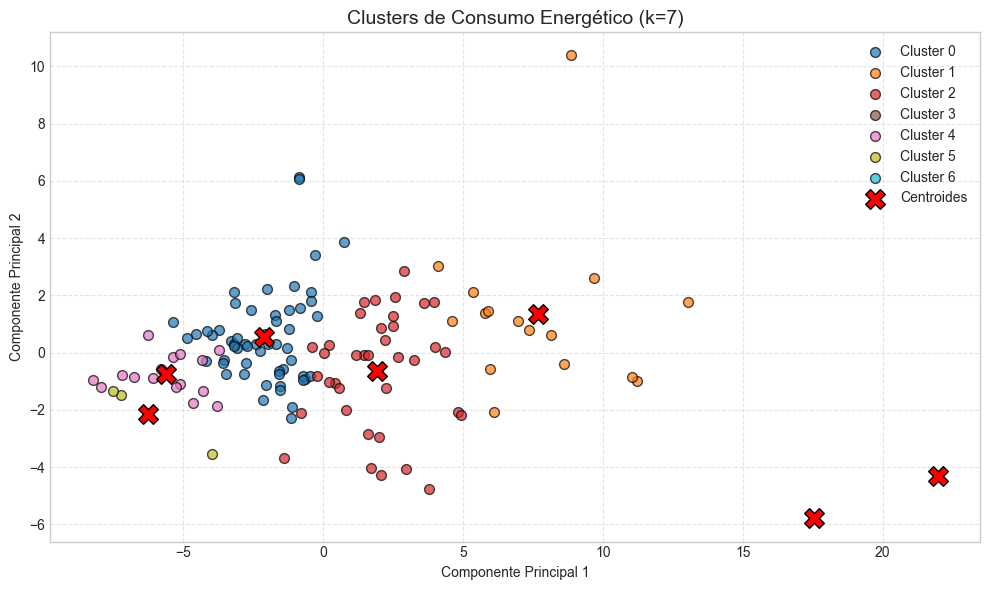

In [108]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
centroids_pca = pca.transform(centroids)

plt.figure(figsize=(10, 6))
for cluster in range(best_k):
    plt.scatter(
        X_pca[labels == cluster, 0],
        X_pca[labels == cluster, 1],
        label=f'Cluster {cluster}',
        color=cluster_colors(cluster),
        alpha=0.7,
        edgecolor='k',
        s=50
    )

# Centroides
plt.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    marker='X',
    s=200,
    c='red',
    edgecolor='k',
    label='Centroides'
)

plt.title(f'Clusters de Consumo Energético (k={best_k})', fontsize=14)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### 2. PCA 3D

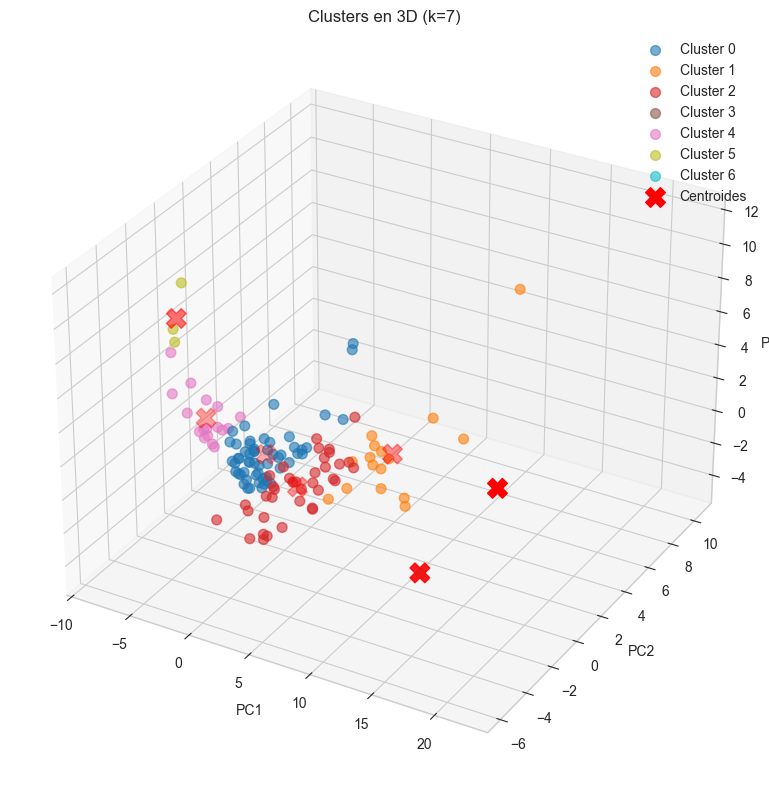

In [109]:
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)
centroids_pca_3d = pca_3d.transform(centroids)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster in range(best_k):
    ax.scatter(
        X_pca_3d[labels == cluster, 0],
        X_pca_3d[labels == cluster, 1],
        X_pca_3d[labels == cluster, 2],
        label=f'Cluster {cluster}',
        color=cluster_colors(cluster),
        alpha=0.6,
        s=50
    )

ax.scatter(
    centroids_pca_3d[:, 0],
    centroids_pca_3d[:, 1],
    centroids_pca_3d[:, 2],
    marker='X',
    s=200,
    c='red',
    label='Centroides'
)

ax.set_title(f'Clusters en 3D (k={best_k})')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.tight_layout()
plt.show()

### Guardar cups y cluster asociacion

In [110]:
df_clusters = pd.DataFrame({
    'CUPS': df_features_final.index,
    'CLUSTER': labels
})
df_clusters.to_csv('dataset/cluster_cups.csv', index=False)



### Visualización de Clusters de su Consumo Original

In [111]:
df_original = pd.read_csv("../../../data/vertical_preprocessed_data_2.csv", sep=";")

cups_con_nan_invierno = ['ceaddbf817fc', 'd0fbcc1108d8']
df_original = df_original[~df_original['cups'].isin(cups_con_nan_invierno)]

cups_con_nan_otoño = ['83c7fbada9b4', 'b476034a2e3d', 'ba38270a360e']
df_original = df_original[~df_original['cups'].isin(cups_con_nan_otoño)]


df_clusters = df_features_final.reset_index()[['cups']].copy()
df_clusters['cluster'] = labels


df_final = pd.merge(df_original, df_clusters[['cups', 'cluster']], on='cups', how='left')

# Reordenar las columnas para que 'cluster' sea la segunda
column_order = ['cups', 'cluster'] + [col for col in df_final.columns if col not in ['cups', 'cluster']]
df_final = df_final[column_order]

df_final.to_csv('dataset/datos_consumo_con_clusters.csv', index=False, sep=';')

### 1. Distribución de Series por Cluster

cluster
0    56
1    16
2    37
3     1
4    17
5     3
6     1
Name: count, dtype: int64


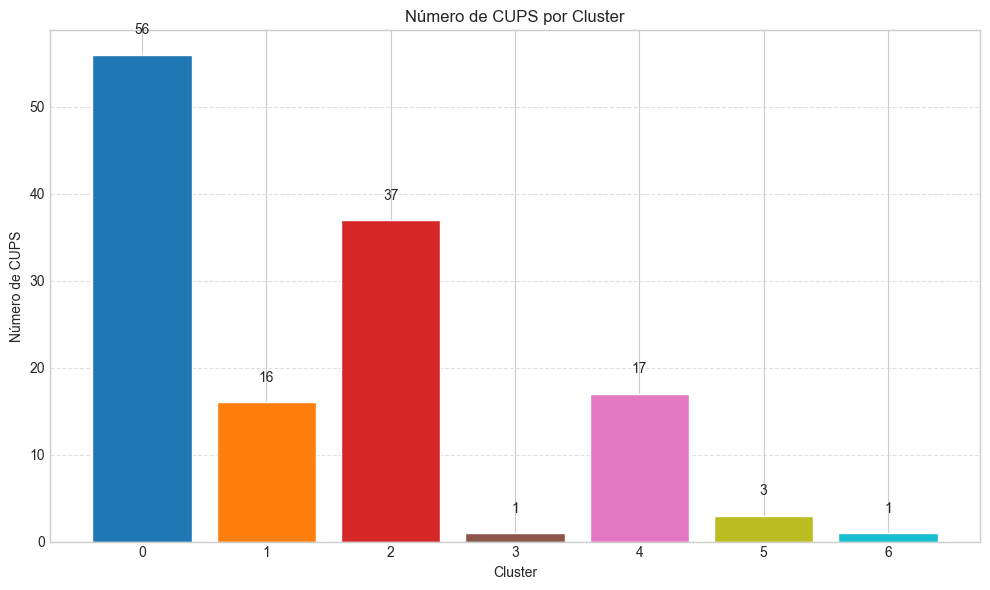

In [114]:
cluster_counts = df_clusters['cluster'].value_counts().sort_index()
print(df_clusters['cluster'].value_counts().sort_index())

plt.figure(figsize=(10, 6))
bars = plt.bar(
    cluster_counts.index.astype(int),
    cluster_counts.values,
    color=[cluster_colors(int(i)) for i in cluster_counts.index]
)

plt.title('Número de CUPS por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de CUPS')
plt.xticks(cluster_counts.index.astype(int))
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 2,
        str(int(height)),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

### 2. Superposición de Series con Centroides

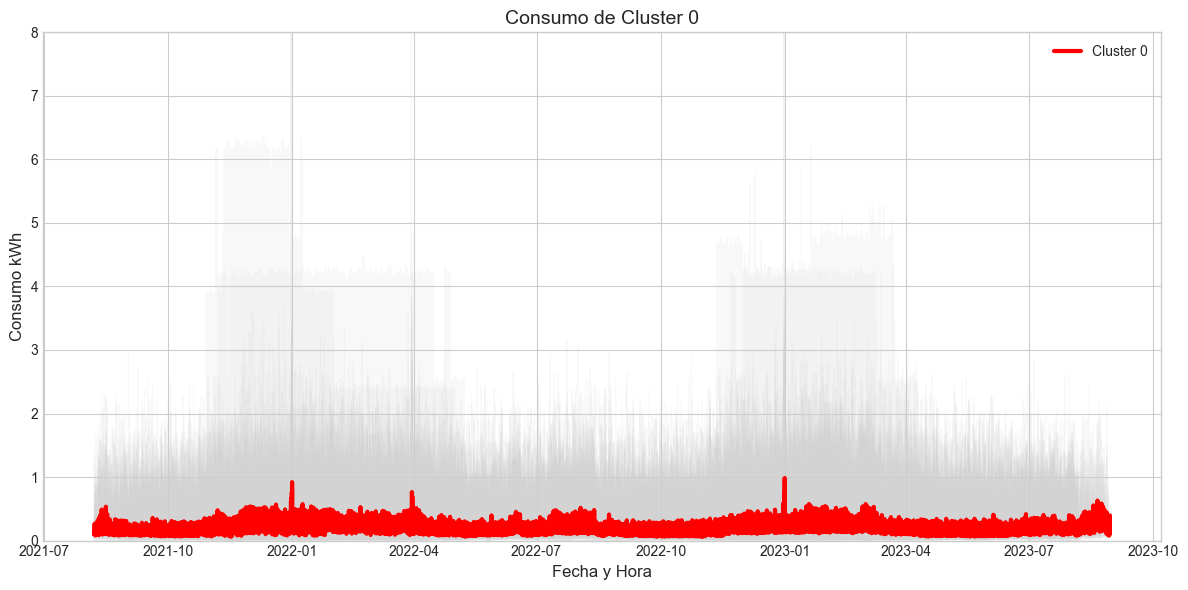

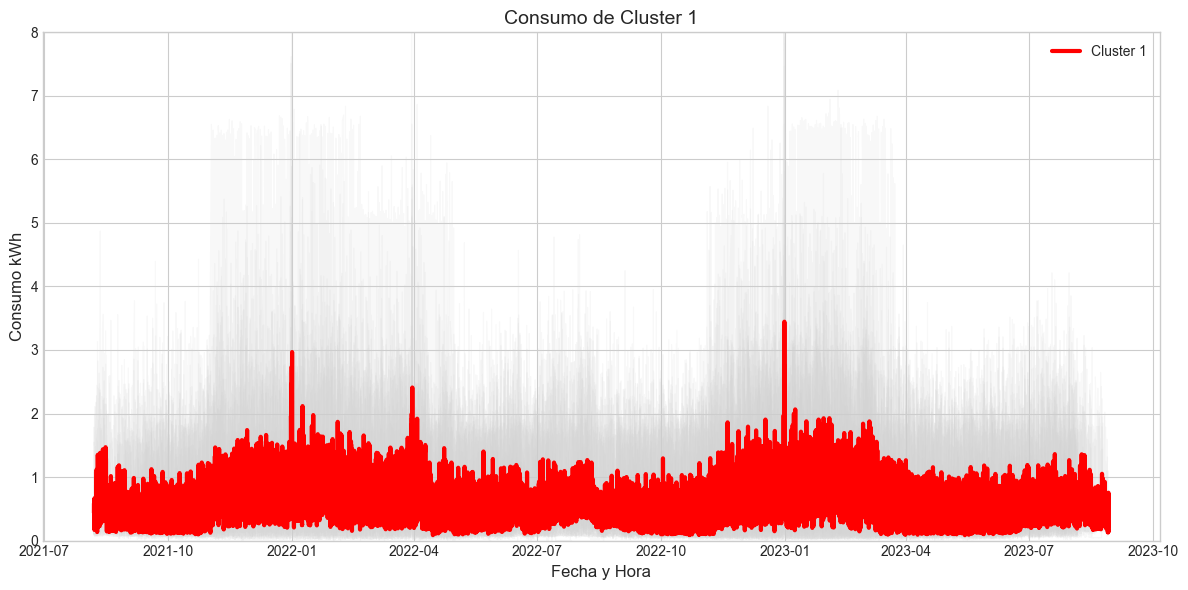

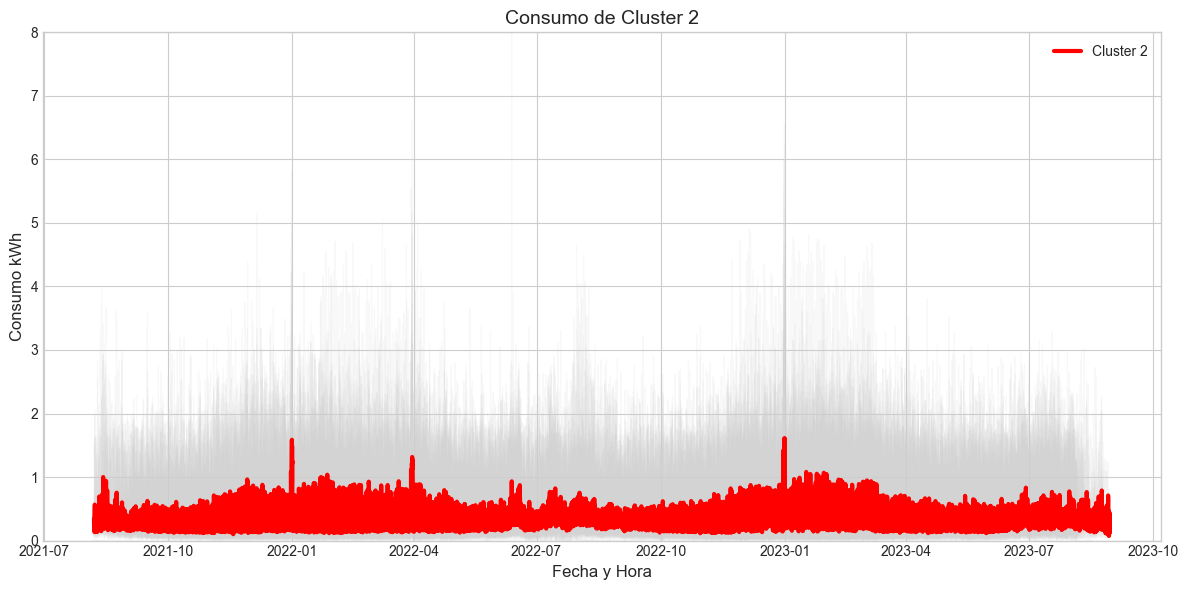

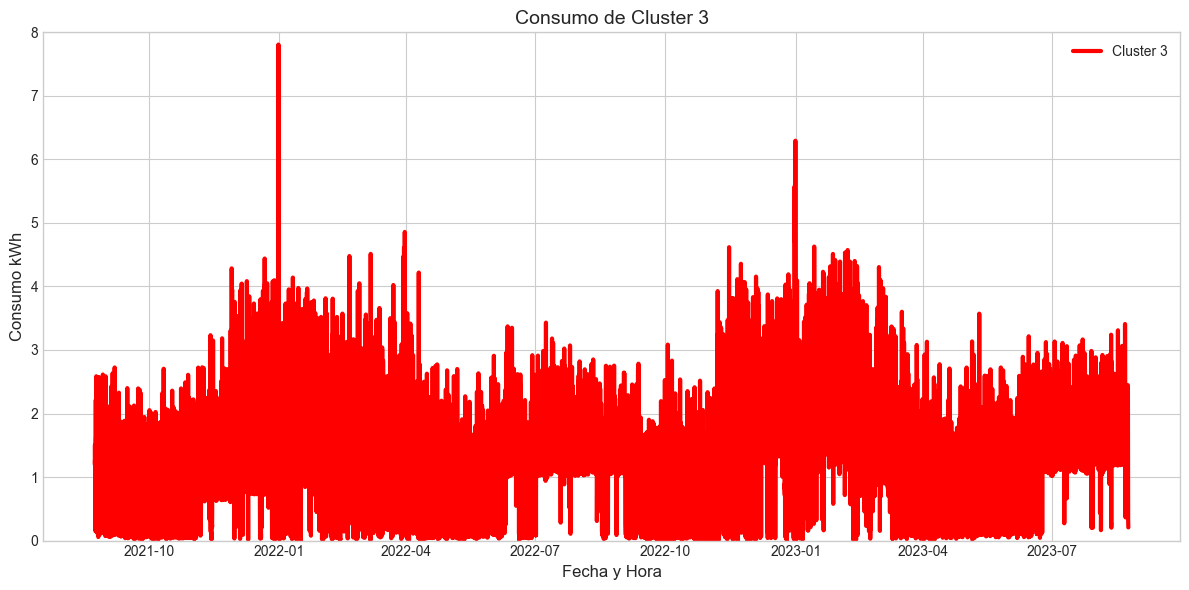

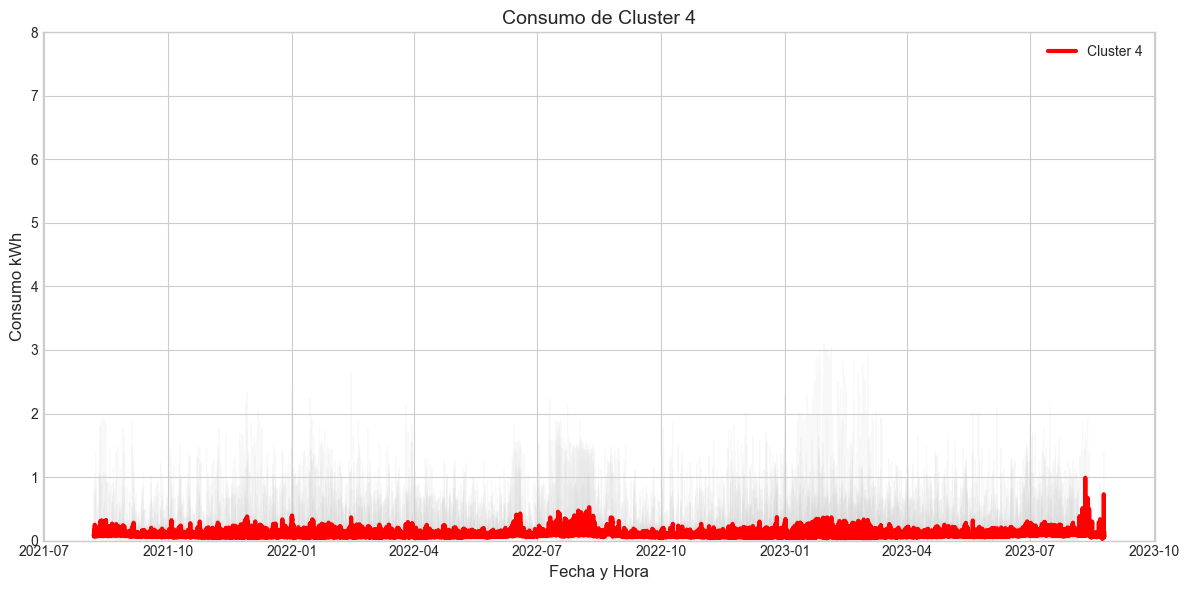

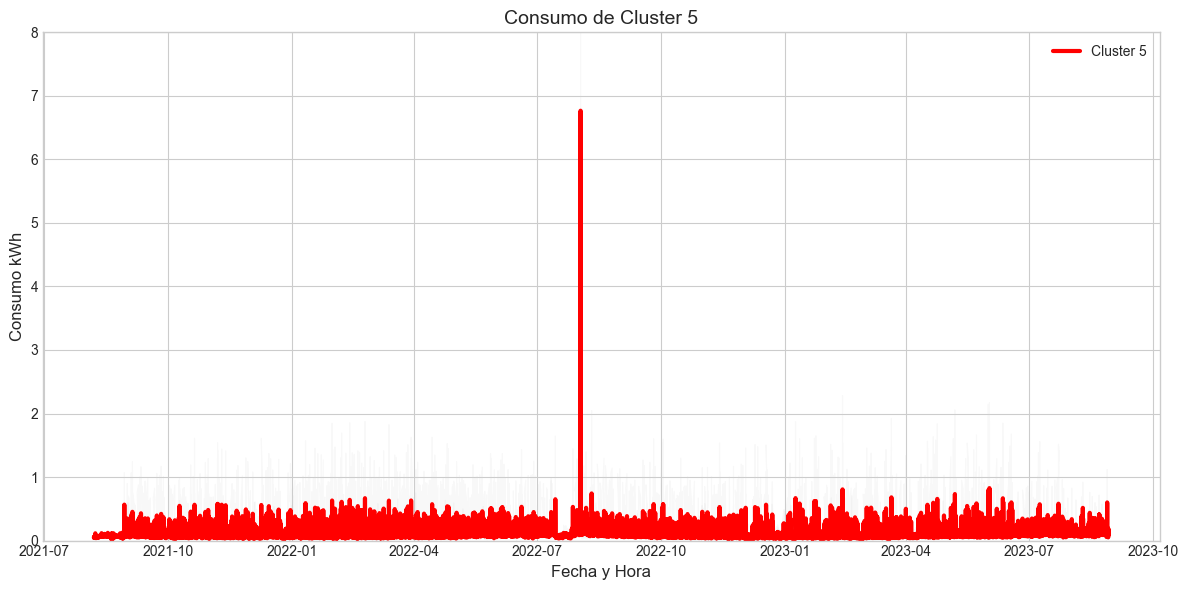

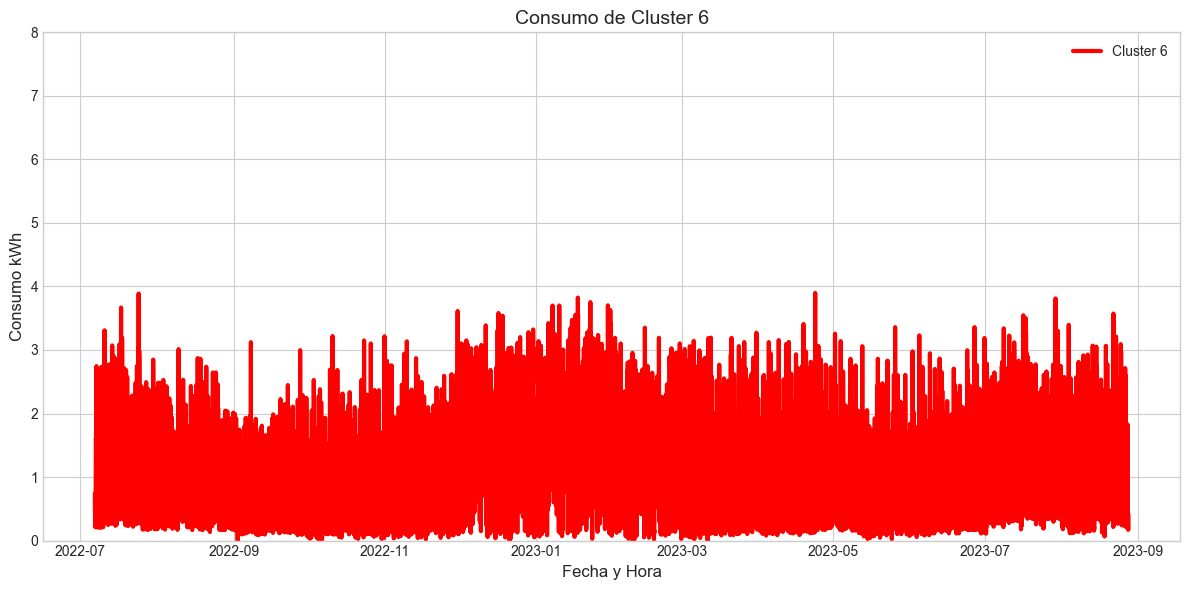

In [115]:
df = pd.read_csv("dataset/datos_consumo_con_clusters.csv", sep=';')

df['hora'] = df['hora'].astype(int)

df['datetime'] = pd.to_datetime(df['fecha']) + pd.to_timedelta(df['hora'], unit='h')

clusters = sorted(df['cluster'].unique())

for cluster in clusters:
    plt.figure(figsize=(12, 6))

    cluster_data = df[df['cluster'] == cluster]
    
    for cups_id in cluster_data['cups'].unique():
        cups_series = cluster_data[cluster_data['cups'] == cups_id]
        plt.plot(cups_series['datetime'], cups_series['consumo_kWh'], color='lightgray', alpha=0.15, linewidth=0.8)
    
    cluster_center = cluster_data.groupby('datetime')['consumo_kWh'].mean()
    plt.plot(cluster_center.index, cluster_center.values, label=f'Cluster {int(cluster)}', linewidth=3, color='red')

    plt.title(f'Consumo de Cluster {int(cluster)}', fontsize=14)
    plt.xlabel('Fecha y Hora', fontsize=12)
    plt.ylabel('Consumo kWh', fontsize=12)
    plt.grid(True)
    plt.legend()
    
    # Fijar el rango del eje Y de 0 a 8 kWh
    plt.ylim(0, 8)
    
    plt.tight_layout()
    plt.show()
